In [1]:
%pylab inline
#%matplotlib qt # for popout plots
from __future__ import division # use so 1/2 = 0.5, etc.
import ssd
import scipy.signal as signal
from IPython.display import Audio, display
from IPython.display import Image, SVG

Populating the interactive namespace from numpy and matplotlib


In [2]:
pylab.rcParams['savefig.dpi'] = 100 # default 72
#pylab.rcParams['figure.figsize'] = (6.0, 4.0) # default (6,4)
#%config InlineBackend.figure_formats=['png'] # default for inline viewing
%config InlineBackend.figure_formats=['svg'] # SVG inline viewing
#%config InlineBackend.figure_formats=['pdf'] # render pdf figs for LaTeX

# **Wavefile Import/Export and Player**

Beyond the typical `imports`, you now include the line below to be able to use the `Audio` control. The module `ssd` contains the functions `fs, x = ssd.from_wave("file.wav")` and `ssd.to_wave("file_name",fs,x)` for importing and exporting wav files to the Python workspace.
```python
from IPython.display import Audio, display
```
For example import one of three audio test vectors recorded at 8 ksps:

In [3]:
fs,xs = ssd.from_wav('OSR_us_000_0018_8k.wav') # female US
#fs,xs = ssd.from_wav('OSR_us_000_0030_8k.wav') # male US
#fs,xs = ssd.from_wav('OSR_uk_000_0050_8k.wav') # male UK

Add some noise to the imported `*.wav` file and the then re-save the array `y` to `*.wav` to allow playing the file using the `Audio` control in the IPython notebook.

In [4]:
y = xs + 0.01*randn(len(xs))
ssd.to_wav('xs.wav',fs,y)

In [6]:
ls *.wav

m0_hat.wav              OSR_us_000_0018_8k.wav  xm.wav  ydd.wav
OSR_uk_000_0050_8k.wav  OSR_us_000_0030_8k.wav  xs.wav  yp2.wav


In [5]:
Audio('xs.wav')

# Support Code

The support code is now brought into this notebook via the Python code module `comm1_support.py`:

In [6]:
import comm1_support as comm1

# Double-Sideband Modulation (DSB)

* Let $A(t) \propto m(t)$, the message signal, thus
\begin{align}
   x_c(t) = A_c m(t) \cos(2\pi f_c t)
\end{align}
* From the modulation theorem it follows that
\begin{align}
		X_c(f) = \frac{1}{2}A_cM(f-f_c) + \frac{1}{2}A_cM(f+f_c)
\end{align}
* Now construct a simple model of the modulator in Python using an upsampling factor of 12
* With an input sampling rate of 8 ksps this makes the working sampling rate 96 ksps
* To make the resampling easier I have encapsulated the needed DSP algorithms in the *class* `rate_change(self,M_change = 12,fcutoff=1/2,N_filt_order=8)`
* This is followed by a quick check of the frequency response of the interpolation and decimation lowpass filter

In [7]:
by12 = comm1.rate_change(M_change=12,fcutoff=1.0,N_filt_order=12)

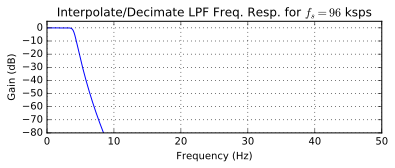

In [8]:
comm1.freqz_resp(by12.b,by12.a,mode='dB',fs=96,fsize=(6,2))
grid()
title(r'Interpolate/Decimate LPF Freq. Resp. for $f_s = 96$ ksps')
ylim([-80,5]);

## Test Signal Generation and Spectrum Verification

In [9]:
Tspan = 10 # Time span in seconds

In [10]:
# Create a digital data source at Rb = 1000 bps
import digitalcom as dc
PN,b,data = dc.NRZ_bits(1000*Tspan,8000/1000)

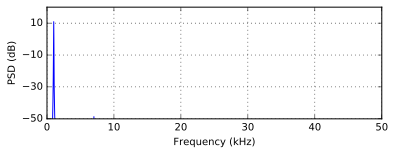

In [11]:
t = arange(0,Tspan,1/8000)
xm = cos(2*pi*1000*t)
#xm = 3*xs[20000:len(t)+20000] # use the speech file
#xm = 1/1*PN # 100 bps digital data
xm_up = by12.up(xm)
figure(figsize=(6,2))
psd(xm_up,2**12,8*12);
ylabel(r'PSD (dB)')
ylim([-50,20])
xlabel(r'Frequency (kHz)');

In [12]:
ssd.to_wav('xm.wav',fs,xm/2)
Audio('xm.wav')

## DSB Modulator and Spectrum Verification

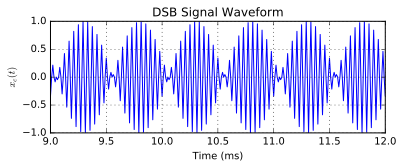

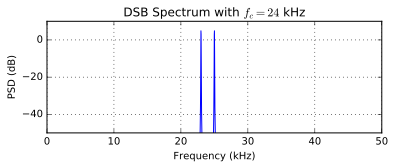

In [13]:
t_up = arange(0,Tspan,1/(8000*12))
# Multiply the message signal by cos(wc*t)
x_c = xm_up*cos(2*pi*24000*t_up)
figure(figsize=(6,2))
plot(t_up[800:1200]*1000,x_c[800:1200])
xlim([9,12])
title(r'DSB Signal Waveform')
xlabel(r'Time (ms)')
ylabel(r'$x_c(t)$')
grid();
figure(figsize=(6,2))
psd(x_c,2**12,8*12)
ylim([-50,10])
title(r'DSB Spectrum with $f_c = 24$ kHz')
ylabel(r'PSD (dB)')
xlabel(r'Frequency (kHz)');

## Coherent Demodulator and Spectrum Verification

* The received signal is multiplied by the signal $2\cos(2\pi f_c t)$, which is synchronous with the transmitter carrier

* For an ideal channel $x_r(t) = x_c(t)$, so
\begin{align}
	d(t) &= \big[A_c m(t)\cos(2\pi f_c t)\big]\, 2\cos(2\pi f_c t) \\
		&= A_c m(t) + A_c m(t) \cos(2\pi (2f_c)t)
\end{align}
where we have used the trig identity $2\cos^2x = 1 + \cos 2x$ or more generally
\begin{align}
    \cos(x)\cos(y) = \frac{1}{2} \cos(x+y) + \frac{1}{2} \cos(x-y)
\end{align}
**Note:** You will be using this identity a lot
* Suppose that $\theta(t)$ is a constant or slowly varying, then the $\cos\theta(t)$ appears as a fixed or time varying attenuation factor
* Even a slowly varying attenuation can be very detrimental from a distortion standpoint
* If say $\theta(t) = \Delta f t$ and $m(t) = \cos(2\pi f_m t)$, then
\begin{align}
	y_D(t) = \frac{1}{2}\left[ \cos[2\pi(f_m - \Delta f)t] + \cos[2\pi(f_m + \Delta f)t]\right]
\end{align}
which is the sum of two tones
* Being able to generate a coherent local reference is also a practical manner

In [35]:
t_up

array([  0.00000000e+00,   1.04166667e-05,   2.08333333e-05, ...,
         9.99996875e+00,   9.99997917e+00,   9.99998958e+00])

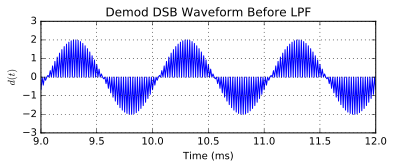

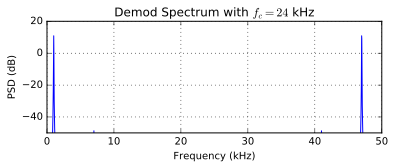

In [14]:
d = 2*x_c*cos(2*pi*24000*t_up)
figure(figsize=(6,2))
#plot(t_up[800:1200]*1000,d[800:1200])
plot(t_up*1000,d)
xlim([9,12])
#xlim([0,100])
title(r'Demod DSB Waveform Before LPF')
xlabel(r'Time (ms)')
ylabel(r'$d(t)$')
grid();
figure(figsize=(6,2))
psd(d,2**12,8*12)
ylim([-50,20])
title(r'Demod Spectrum with $f_c = 24$ kHz')
ylabel(r'PSD (dB)')
xlabel(r'Frequency (kHz)');

### Recover the Message Using a LPF

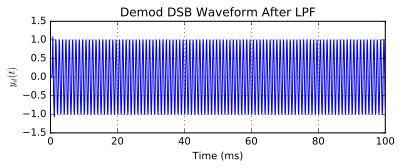

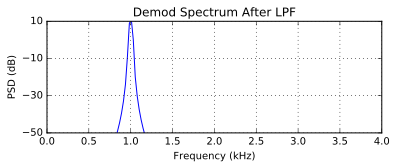

In [15]:
yd = signal.lfilter(by12.b,by12.a,d)
figure(figsize=(6,2))
#plot(t_up[800:1200]*1000,yd[800:1200])
#plot(t_up[:50000]*1000,yd[:50000])
plot(t_up*1000,yd)
#xlim([0,500])
xlim([0,100])
title(r'Demod DSB Waveform After LPF')
xlabel(r'Time (ms)')
ylabel(r'$y_d(t)$')
grid();
figure(figsize=(6,2))
psd(yd,2**12,8*12)
ylim([-50,10])
xlim([0,4])
title(r'Demod Spectrum After LPF')
ylabel(r'PSD (dB)')
xlabel(r'Frequency (kHz)');

In [16]:
ydd = by12.dn(d)
ssd.to_wav('ydd.wav',fs,ydd)
Audio('ydd.wav')

# Amplitude Modulation

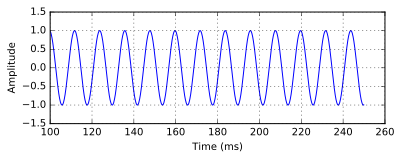

In [17]:
t = arange(0,Tspan,1/8000)
xm = cos(2*pi*1000*t)
#xm = 20*xs[20000:len(t)+20000] # use the speech file
#xm = 1/1*PN # 100 bps digital data
xm_up = by12.up(xm)
figure(figsize=(6,2))
plot(t[800:2000]*1000,xm_up[800:2000]);
grid()
#xlim([0,10])
ylabel(r'Amplitude')
xlabel(r'Time (ms)');

## Generate AM

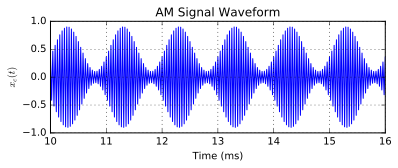

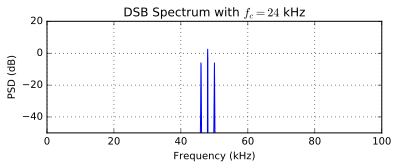

In [18]:
t_up = arange(0,Tspan,1/(8000*12))
# Multiply the message signal by cos(wc*t)
a_mod = 0.8
x_c = 0.5*(1+a_mod*xm_up)*cos(2*pi*24000*t_up)
figure(figsize=(6,2))
plot(t_up[800:2000]*1000,x_c[800:2000])
xlim([10,16])
title(r'AM Signal Waveform')
xlabel(r'Time (ms)')
ylabel(r'$x_c(t)$')
grid();
figure(figsize=(6,2))
psd(x_c,2**12,8*24)
ylim([-50,20])
title(r'DSB Spectrum with $f_c = 24$ kHz')
ylabel(r'PSD (dB)')
xlabel(r'Frequency (kHz)');

## Demodulate AM

AM can be demodulated coherently, but why? Evenvelope detection is sufficient and easy to implement.

A discrete-time signal processing model actually takes a bit more work than the simple diode and RC lowpass filter found in the notes and text. There are several ways to accomplish the simple detector. As a first attempt I will start by using a biased version of the `sign()` function (also in MATLAB) to effectively multiply the signal by one when $x_c(t)$ is positive and zero when $x_c(t)$ is negative. We will be using the coresponding theoretical function $\text{sgn}()$ in the discussion of the Hilbert transform a little later. Formally,
\begin{align}
    \text{sgn}(x) = \text{sign}(x) = \begin{cases}
            1, & x > 0 \\
            -1, & x < 0
            \end{cases}
\end{align}

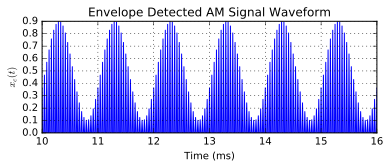

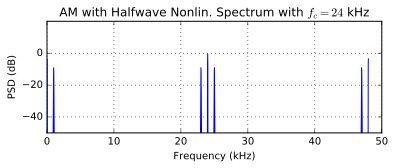

In [19]:
# Envelope Detector
x_env = x_c*(1+sign(x_c))/2
figure(figsize=(6,2))
plot(t_up[800:2000]*1000,x_env[800:2000])
xlim([10,16])
title(r'Envelope Detected AM Signal Waveform')
xlabel(r'Time (ms)')
ylabel(r'$x_c(t)$')
grid();
figure(figsize=(6,2))
psd(x_env,2**12,8*12)
ylim([-50,20])
title(r'AM with Halfwave Nonlin. Spectrum with $f_c = 24$ kHz')
ylabel(r'PSD (dB)')
xlabel(r'Frequency (kHz)');

The next step is to implement a lowpass filter. In the simple analog circuit diode RC filter combination forms a nonlinear system, so the detailed analysis is not as easy as it looks. In the discrete-time you can implement a first-order discrete-time lowpass that will be fulled decoupled from the envelope detector, hence nonlinear processing follwed by linear processing with no interaction.

A first-order lowpass can be implemented via the difference equation
\begin{align}
    y[n] = a y[n-1] + (1-a) x[n],
\end{align}
where $a$ is set to model the $RC$ time constant of interest. Consider the impulse response
\begin{align}
    h_a(t) = e^{-t/RC} u(t)
\end{align}
If you sample this impulse response at rate $f_s$ Hz, you obtain an *impulse invariant* discrete-time impulse response
\begin{align}
    h[n] = e^{-n/(fs\cdot RC)} u[n] = (e^{-2\pi f_3/f_s})^n u[n]
\end{align}
where $f_3 = 1/(2\pi RC)$ is the RC lowpass 3dB cutoff frequency. In the difference model
\begin{align}
    a = e^{-2\pi f_3/f_s}
\end{align}

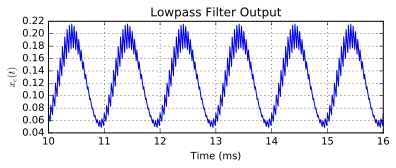

In [20]:
# Define a for  f3 = 1000 Hz
a = exp(-2*pi*1000/96000)
e_o = signal.lfilter([1-a],[1,-a],x_env)
figure(figsize=(6,2))
plot(t_up[800:2000]*1000,e_o[800:2000])
xlim([10,16])
title(r'Lowpass Filter Output')
xlabel(r'Time (ms)')
ylabel(r'$x_c(t)$')
grid();

The above plot shows that if is difficult to filter the envelope detector output to remove the carrier cycles. Reducing the cutoff frequency $f_3$ helps with carrier removal, but also takes the signal. Consider a higher-order filter.

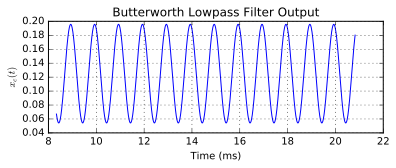

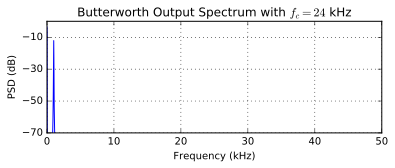

In [21]:
# Replace 1st-order Filter with N = 5 Butterworth
b5,a5 = signal.butter(5,2*1000/96000)
e_o = signal.lfilter(b5,a5,x_env)
figure(figsize=(6,2))
plot(t_up[800:2000]*1000,e_o[800:2000])
#xlim([10,16])
title(r'Butterworth Lowpass Filter Output')
xlabel(r'Time (ms)')
ylabel(r'$x_c(t)$')
grid();
figure(figsize=(6,2))
psd(e_o,2**12,8*12)
ylim([-70,0])
title(r'Butterworth Output Spectrum with $f_c = 24$ kHz')
ylabel(r'PSD (dB)')
xlabel(r'Frequency (kHz)');

In the above two plots you see:
* The time domain waveform is now very clean, with no obvious sign of the carrier and its harmonics
* The spectrum plot shows down to 60 dB below the 1000 Hz recovered message, there is nothing visible

In [22]:
ydd = by12.dn(e_o)
ssd.to_wav('ydd.wav',fs,ydd)
Audio('ydd.wav')

# Example: Multiple Sinusoids and Finding min(m(t))

* Suppose that $m(t)$ is a sum of multiple sinusoids (multi-tone AM)
\begin{align}
		m(t) = \sum_{k=1}^M A_{k} \cos(2\pi f_k t + \phi_k)
\end{align}
where $M$ is the number of sinusoids, $f_k$ values might be constrained over some band of frequencies $W$, e.g., $f_k \leq W$, and the phase values $\phi_k$ can be any value on $[0,2\pi]$
* To find $m_n(t)$ we need to find $\min m(t)$
* A lower bound on $\min m(t)$ is $-\sum_{k=1}^M A_k$; why?
* The worst case value may not occur in practice depending upon the phase and frequency values, so we may have to resort to a numerical search or a plot of the waveform
* Suppose that $M=3$ with $f_k = \{65, 100, 35\}$ Hz, $A_k = \{2, 3.5, 4.2\}$, and $\phi_k = \{0, \pi/3,-\pi/4\}$ rad
* Note the fundamental frquency here is 5 Hz (found using the gcd())  

In [23]:
from IPython.display import display
from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')
import sympy as sym
sym.gcd([65,100,35])

5

In [3]:
def M_sinusoids(Nsamp,f,A,phi,fsamp):
    """
    m,t = M_sinusoids(Nsamp,f,A,phi,fsamp)
    
    Mark Wickert, February 2015

    For a sum of sinusoids having amplitude and phase values 
    stored in vectors f and phi respectively. The number of 
    samples in the waveform will be Nsamp and the sampling 
    rate will be fsamp
    """
    n = arange(0,Nsamp)
    t = n/fsamp
    M = len(f)
    m = zeros_like(t)

    for k in range(M):
        m += A[k]*cos(2*pi*f[k]*t + phi[k])
    return m, t

min(m) = -7.2462 and lower bound -sum([2, 3.5, 4.2] = -9.7000


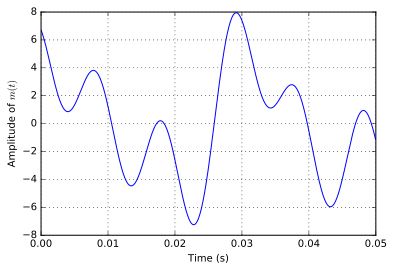

In [26]:
m,t = M_sinusoids(1000,[65, 100, 35],[2, 3.5, 4.2],[0, pi/3, -pi/4], 20000)
plot(t,m)
ylabel(r'Amplitude of $m(t)$')
xlabel(r'Time (s)')
grid();
print('min(m) = %6.4f and lower bound -sum([2, 3.5, 4.2] = %6.4f' \
      % ((min(m),-sum([2, 3.5, 4.2]))))

# Plotting the Spectrum of a Multi-Tone AM Signal
Make use of the `ssd.line_spectra(()` function by filling arrays with the proper frequency values and the amplitude values for a two-sided spectrum. The AM signal is assumed to be of the form
\begin{align}
    x_c(t) = A_c\left[1 + \frac{a}{|\min{m(t)}|}\sum_{k=1}^M A_{m,k} \cos(2\pi f_{m,k}t + \theta_{m,k}) \right] \cos(2\pi f_c t)
\end{align}
where
\begin{align}
    m(t) = \sum_{k=1}^M A_{m,k} \cos(2\pi f_{m,k}t + \theta_{m,k})
\end{align}
The function `multi_tone_AM_spectra(A_c,f_c,a_index,min_m,A_k,f_mk,theta_mk)` takes all of the parameters in the above equation as scalars for the first four arguments and lists (or `ndarrays`) for the remaining three sinuusoidal modulation parameters. The function returns `ndarrays` for inserting into `ssd.lines_spectra()`.

In [27]:
def multi_tone_AM_spectra(A_c,f_c,a_index,min_m,A_k,f_mk,theta_mk):
    """
    Organize the parameters of multi-tone AM modulation into a form
    suitable for using ssd.line_spectra for magnitude and phase plots.
    
    A_c, f_c, a_index, and min_m are scalar parameters
    A_k, f_mk, and theta_mk are 1D lists or ndarrays of the
    same length, e.g., M
    
    Mark Wickert February 2017
    """
    M = len(A_k)
    f_k = zeros(2*M + 1)
    X_k = zeros(2*M + 1,dtype=complex128)
    f_k[0] = f_c
    X_k[0] = A_c/2
    print('f_c = %4.2f, A_c = %4.2f' % (f_k[0],2*abs(X_k[0])))
    scale_factor = A_c*a_index/(4*abs(min_m))
    for k in range(M):
        X_k[2*k+1] = scale_factor*A_k[k]*exp(1j*theta_mk[k])
        f_k[2*k+1] = f_c + f_mk[k]
        X_k[2*k+2] = scale_factor*A_k[k]*exp(-1j*theta_mk[k])
        f_k[2*k+2] = f_c - f_mk[k]
        print('f_m[%d]_up = %4.2f, |A_m| = %4.2f, /_A_m = %4.2f (rad)' % \
              (k,f_k[2*k+1],2*abs(X_k[2*k+1]),angle(X_k[2*k+2])))
        print('f_m[%d]_low = %4.2f, |A_m| = %4.2f, /_A_m = %4.2f (rad)' % \
              (k,f_k[2*k+2],2*abs(X_k[2*k+2]),angle(X_k[2*k+2])))
    return f_k, X_k

### Text Example 3.1

In [28]:
f_k, X_k = multi_tone_AM_spectra(10,10,0.5,-4.3642,
                                 [4,2],[1,2],[-pi/9,-pi/2])

f_c = 10.00, A_c = 10.00
f_m[0]_up = 11.00, |A_m| = 2.29, /_A_m = 0.35 (rad)
f_m[0]_low = 9.00, |A_m| = 2.29, /_A_m = 0.35 (rad)
f_m[1]_up = 12.00, |A_m| = 1.15, /_A_m = 1.57 (rad)
f_m[1]_low = 8.00, |A_m| = 1.15, /_A_m = 1.57 (rad)


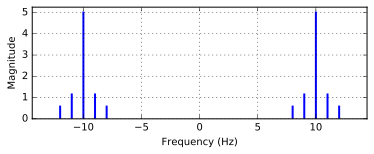

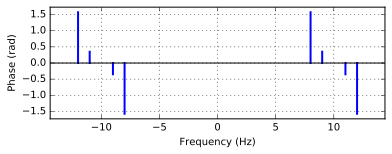

In [29]:
ssd.line_spectra(f_k,X_k,'mag',fsize=(6,2))
ssd.line_spectra(f_k,X_k,'phase',fsize=(6,2))

# Hilbert Transform

Consider the design a Hilbert transforming digital filter. The `scipy.signal` module is capable of such designs.

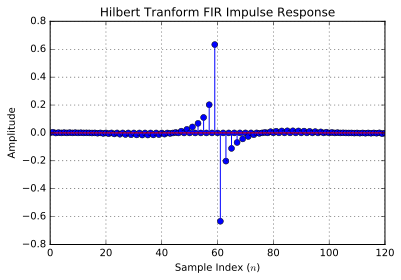

In [30]:
b31 = signal.remez(31,array([0, .05,.1,.9,0.95,1])/2,[.1,1,.1],
                   Hz=1,type='hilbert')
b63 = signal.remez(63,array([0, .01,.05,.95,0.99,1])/2,[.01,1,.01],
                   Hz=1,type='hilbert')
b121 = signal.remez(121,array([0, .01,.05,.95,0.99,1])/2,[.01,1,.01],
                    Hz=1,type='hilbert')
stem(b121)
title(r'Hilbert Tranform FIR Impulse Response')
ylabel(r'Amplitude')
xlabel(r'Sample Index ($n$)')
grid();

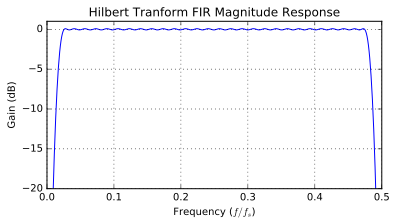

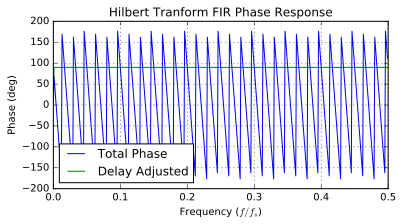

In [31]:
f = arange(0,.5,.001)
w,H = signal.freqz(b121,1,2*pi*f)
figure(figsize=(6,3))
plot(f,20*log10(abs(H)))
ylim([-20,1])
title(r'Hilbert Tranform FIR Magnitude Response')
ylabel(r'Gain (dB)')
xlabel(r'Frequency ($f/f_s$)')
grid();
figure(figsize=(6,3))
plot(f,angle(H)*180/pi)
plot(f,(unwrap(angle(H))+2*pi*(121-1)/2*f)*180/pi)
title(r'Hilbert Tranform FIR Phase Response')
ylabel(r'Phase (deg)')
xlabel(r'Frequency ($f/f_s$)')
legend((r'Total Phase',r'Delay Adjusted'),loc='lower left')
grid();

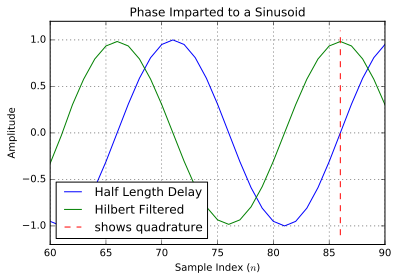

In [43]:
n = arange(0,100)
x = cos(2*pi*0.05*n)
b_del = zeros(32)
b_del[-1] = 1 # place a 1 at the end of the 32 tap delay
y_del = signal.lfilter(b_del,1,x)
y_hil = signal.lfilter(b63,1,x)
plot(n,y_del)
plot(n,y_hil)
plot([86,86],[-1.1,1.1],'r--')
ylim([-1.2,1.2])
xlim([60,90])
title(r'Phase Imparted to a Sinusoid')
ylabel(r'Amplitude')
xlabel(r'Sample Index ($n$)')
legend((r'Half Length Delay',r'Hilbert Filtered',r'shows quadrature'),loc='lower left')
grid();

# Single Sideband

Using the filter designed above we can create a single sideband signal at baseband, and then shift it up to a desired carrier frequency.

In [44]:
def analytic_signal(m,b_hilbert,usb_lsb='upper'):
    b_del = zeros((len(b_hilbert)+1)//2)
    b_del[-1] = 1
    y_del = signal.lfilter(b_del,1,m)
    y_hil = signal.lfilter(b_hilbert,1,m)
    if usb_lsb == 'upper':
        return y_del - 1j*y_hil
    else:
        return y_del + 1j*y_hil

In [45]:
#fs,xs = ssd.from_wav('OSR_us_000_0018_8k.wav') # female US
fs,xs = ssd.from_wav('OSR_us_000_0030_8k.wav') # male US
#fs,xs = ssd.from_wav('OSR_uk_000_0050_8k.wav') # male UK

In [46]:
ssd.to_wav('xs.wav',8000,xs)
Audio('xs.wav')

In [47]:
by12 = comm1.rate_change(M_change=12,fcutoff=0.8,N_filt_order=12)

## Transmit Signal Generation

### Create Analytic Signal Version of m(t)

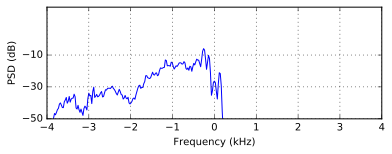

In [107]:
Tspan = 10 # Time span in seconds
t = arange(0,Tspan,1/8000)
#xm = cos(2*pi*1000*t)
xm = 3*xs[20000:len(t)+20000] # use the speech file
#xm = 1/1*PN # 100 bps digital data
xm_SSB = analytic_signal(xm,b121,'lower')
xm_up = by12.up(xm_SSB)
figure(figsize=(6,2))
psd(xm_up,2**12,8*12);
xlim([-4,4])
ylabel(r'PSD (dB)')
ylim([-50,20])
xlabel(r'Frequency (kHz)');

### Up Convert the Analytic Signal and Take the Real Part

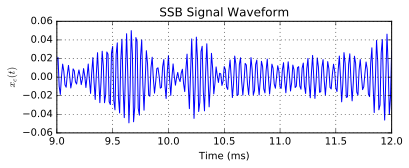

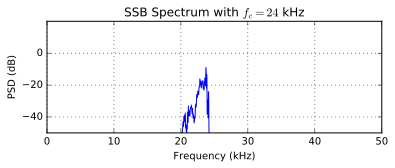

In [108]:
t_up = arange(0,Tspan,1/(8000*12))
# Multiply the message signal by cos(wc*t)
x_c = real(xm_up*exp(1j*2*pi*24000*t_up))
figure(figsize=(6,2))
plot(t_up[800:1200]*1000,x_c[800:1200])
xlim([9,12])
title(r'SSB Signal Waveform')
xlabel(r'Time (ms)')
ylabel(r'$x_c(t)$')
grid();
figure(figsize=(6,2))
psd(x_c,2**12,8*12)
ylim([-50,20])
title(r'SSB Spectrum with $f_c = 24$ kHz')
ylabel(r'PSD (dB)')
xlabel(r'Frequency (kHz)');

## Receiver Using Coherent Demodulation

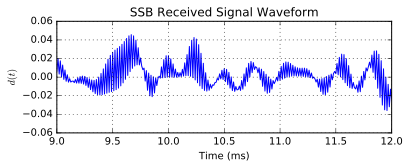

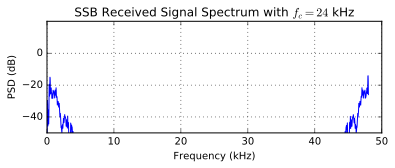

In [114]:
# Multiply received signal by cos() at fc
d = x_c*cos(2*pi*24200*t_up)
figure(figsize=(6,2))
plot(t_up[800:1400]*1000,d[800:1400])
xlim([9,12])
title(r'SSB Received Signal Waveform')
xlabel(r'Time (ms)')
ylabel(r'$d(t)$')
grid();
figure(figsize=(6,2))
psd(d,2**12,8*12)
ylim([-50,20])
title(r'SSB Received Signal Spectrum with $f_c = 24$ kHz')
ylabel(r'PSD (dB)')
xlabel(r'Frequency (kHz)');

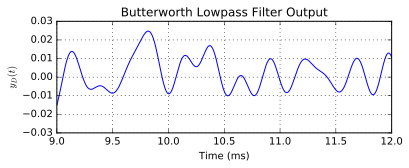

In [115]:
# Lowpass Filter
b5,a5 = signal.butter(5,2*4000/96000)
yD = signal.lfilter(b5,a5,d)
figure(figsize=(6,2))
plot(t_up[800:2000]*1000,yD[800:2000])
xlim([9,12])
title(r'Butterworth Lowpass Filter Output')
xlabel(r'Time (ms)')
ylabel(r'$y_D(t)$')
grid();

In [116]:
ydd = by12.dn(yD - mean(yD))
ssd.to_wav('ydd.wav',8000,ydd)
Audio('ydd.wav')

## Receiver Using Carrier Reinsertion and Envelope Detection 

### Carrier Reinsertion with Amplitude K

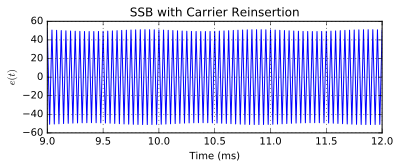

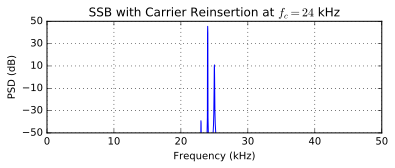

In [93]:
K = 50
e = x_c+K*cos(2*pi*24000*t_up)
figure(figsize=(6,2))
plot(t_up[800:1400]*1000,e[800:1400])
xlim([9,12])
title(r'SSB with Carrier Reinsertion')
xlabel(r'Time (ms)')
ylabel(r'$e(t)$')
grid();
figure(figsize=(6,2))
psd(e,2**12,8*12)
ylim([-50,50])
title(r'SSB with Carrier Reinsertion at $f_c = 24$ kHz')
ylabel(r'PSD (dB)')
xlabel(r'Frequency (kHz)');

### Envelope Detect and Lowpass Filter

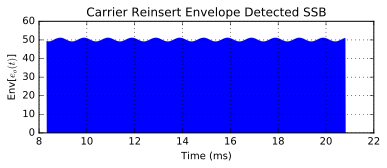

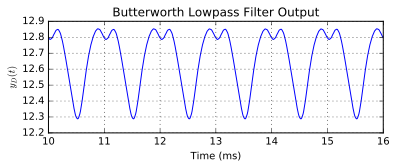

In [94]:
# Envelope Detector
e_o = e*(1+sign(e))/2
figure(figsize=(6,2))
plot(t_up[800:2000]*1000,e_o[800:2000])
#xlim([10,16])
title(r'Carrier Reinsert Envelope Detected SSB')
xlabel(r'Time (ms)')
ylabel(r'Env[$e_o(t)$]')
grid();
# Replace 1st-order Filter with N = 5 Butterworth
b5,a5 = signal.butter(5,2*4000/96000)
yD = signal.lfilter(b5,a5,e_o)
figure(figsize=(6,2))
plot(t_up[800:2000]*1000,yD[800:2000])
xlim([10,16])
title(r'Butterworth Lowpass Filter Output')
xlabel(r'Time (ms)')
ylabel(r'$y_D(t)$')
grid();

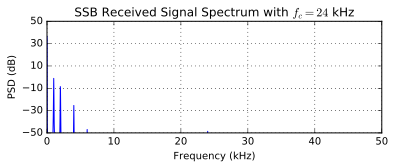

In [95]:
figure(figsize=(6,2))
psd(yD,2**12,8*12)
ylim([-50,50])
title(r'SSB Received Signal Spectrum with $f_c = 24$ kHz')
ylabel(r'PSD (dB)')
xlabel(r'Frequency (kHz)');

In [90]:
ydd = by12.dn(yD - mean(yD))
ssd.to_wav('ydd.wav',8000,ydd)
Audio('ydd.wav')

### Explore the Complex Envelope

In [ ]:
tt = arange(0,0.01,1/96000)
fm = 1000
fc = 24000
Df = 0
K = 10
x_c = real((1/2*exp(1j*2*pi*(fm-Df)*tt)+K)*exp(1j*2*pi*(fc+Df)*tt))
x_cenv = analytic_signal(x_c,b121,'lower')
r = abs((1/2*exp(1j*2*pi*(fm-Df)*tt)+K))

# Frequency Translation and Mixing
In this section we consider the use spectral analysis to access frequency translation and mixing. A simple DSB carrier with multiple sinusoidal tones serving as the message signal. The sampling rate is fixed at 200 kHz.

When a carrier-based signal at $f_c$ is multiplied by a local oscillator (LO) signal $\cos(2\pi f_\text{LO} t)$ the result is two signals, one centered at $f_c + f_\text{LO}$ and another at $|f_c - f_\text{LO}$. If say $x_c(t)$ is a DSB signal, $m(t)\cos(2\pi f_c t)$, then the mixer output is
\begin{align}
    e(t) = x_\text{mix}(t) = \frac{1}{2}m(t)\bigg\{\cos\big[2\pi(f_c + f_\text{LO})t\big] +\cos\big[2\pi(f_c - f_\text{LO})t\big]\bigg\}
\end{align}
In general we may choose to make the sum frequency or the difference frequency the desired output.

* When the output frequency is lower than the input frequency, the difference frequency is of interest. In a superheterodyne receiver the output frequency is also known as the *intermediate* frequency or $f_\text{IF}$. With *highside* tuning we choose the LO frequency to above the input frequency, i.e.,  $f_\text{LO}$ to be $f_c + f_\text{IF}$. For $f_\text{LO} = f_c + f_\text{IF}$ the *image frequency*, which also down-converts to $f_\text{IF}$, is at $f_\text{IMAGE} = f_c + 2f_\text{IF} = f_\text{LO} + f_\text{IF}$. Why? Clearly $f_\text{IMAGE} - f_\text{LO} = f_\text{IF}$. In the example below $f_c = 30$ kHz and $f_\text{IF} = 5$ kHz. We initially set $f_\text{LO} = 35$ kHz. This puts the image frequency at $f_\text{IMAGE} = 30 + 2\times 5 = 40$ kHz.

* When the output frequency is higher than the input frequency either the sum frequency or the difference frequency may be used to obtain $f_\text{IF}$. Suppose 4F_\text{IF} = 50$ kHz, then we may choose $f_\text{LO} = 50 - 30 = 20$ kHz or $f_\text{LO} = 50 + 30 = 80$ kHz.

In [4]:
m,t = M_sinusoids(10000,[100,0.5e3,1.0e3,1.5e3],[2,2,1,0.5],
                  [0,0,0,0],200000)
mi,t = M_sinusoids(10000,[100,0.5e3,1.0e3,1.5e3],[0.5,1,2,2],
                  [0,0,0,0],200000)
fc = 30e3
xc = m*cos(2*pi*fc*t)
fi = (30+2*5)*1e3
xIMAGE = 0.125*mi*cos(2*pi*fi*t)
fLO = 35e3
xLO = cos(2*pi*fLO*t)
xMIX = xc*xLO
xiMIX = xIMAGE*xLO

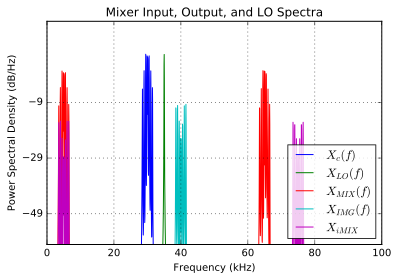

In [5]:
psd(xc,2**12,200);
psd(xLO,2**12,200);
psd(xMIX,2**12,200);
psd(xIMAGE,2**12,200)
psd(xiMIX,2**12,200);
title(r'Mixer Input, Output, and LO Spectra')
legend((r'$X_c(f)$',r'$X_{LO}(f)$',r'$X_{MIX}(f)$',
        r'$X_{IMG}(f)$',r'$X_{iMIX}$'), 
        loc='lower right',framealpha=0.8)
xlabel(r'Frequency (kHz)')
ylim([-60,20]);

K =  2
K =  2
K =  2
K =  2
K =  2


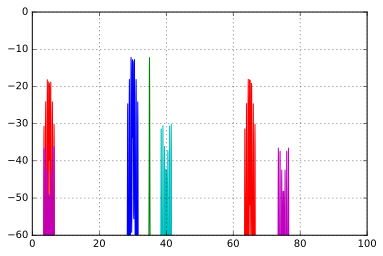

In [13]:
f,Sx = ssd.simple_SA(xc,4096,4096,200,2,'hanning')
plot(f,10*log10(Sx))
f,Sx = ssd.simple_SA(xLO,4096,4096,200,2,'hanning')
plot(f,10*log10(Sx),'g')
f,Sx = ssd.simple_SA(xMIX,4096,4096,200,2,'hanning')
plot(f,10*log10(Sx),'r')
f,Sx = ssd.simple_SA(xIMAGE,4096,4096,200,2,'hanning')
plot(f,10*log10(Sx),'c')
f,Sx = ssd.simple_SA(xiMIX,4096,4096,200,2,'hanning')
plot(f,10*log10(Sx),'m')

ylim([-60,0]);
grid();

In [20]:
import detect_peaks as dp
idx = dp.detect_peaks(Sx,mpd=100)

# Interference with Envelope Detection

In [56]:
A = 100
B = 1
xI = A + 5*cos(2*pi*10e3*t) + B*cos(2*pi*15e3*t)
xQ = B*sin(2*pi*15e3*t)
R = abs(xI + 1j*xQ)

(-60, 30)

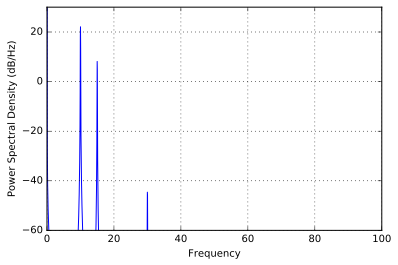

In [57]:
psd(R,2**12,200);
ylim([-60,30])
#plot(R[:100])
#ylim([0, 1.2*A])

# Bandpass Sampling Theory

Create a function for plotting the spectra of sampled bandpass signal. Assume the bandpass spectral shape is $X(f)$, the sampled spectrum is of the form (ignoring gain scaling by $f_s$) is
\begin{align}
    X_s(f) = \sum_{n=-\infty}^\infty X(f-nf_s)
\end{align}
In particular here $X(f)$ is a right triangle shape starting at $f_1$ and stopping at $f_2$, where $f_2 > f_1$. The tuple variable `B = (f1, f2)` holds these two values, which to $(2,3)$.

In [4]:
def BP_spec(f,fs,Ntranslates=10,B=(2,3)):
    """
    Sampled bandpass signal spectrum plot
              f = frequency axis created using arange
             fs = sampling frequency
    Ntranslates = the number of spectrum translates
                  to use in the calculation
              B = (B_lower,B_upper)
    
    Mark Wickert March 2015
    """
    W = B[1]-B[0]
    X = BP_primP(f-B[0],W)+BP_primN(f+B[0],W)
    for k in xrange(Ntranslates):
        plot(f,BP_primP(f-B[0]-k*fs,W)+BP_primN(f+B[0]-k*fs,W),'b')
        plot(f,BP_primP(f-B[0]+k*fs,W)+BP_primN(f+B[0]+k*fs,W),'b')
    plot(f,X,'r')
    title(r'Sampled Signal Spectrum for $f_s$ = %2.2f' % fs)
    ylabel(r'Amplitude')
    xlabel(r'Frequency')
    xlim([-2*B[1],2*B[1]])
    grid();

def BP_primP(f,W=1):
    return ssd.tri(f-W,W)*ssd.rect(f-W/2,W)

def BP_primN(f,W=1):
    return ssd.tri(f+W,W)*ssd.rect(f+W/2,W)

To use the function above (plus two helper functions), you just enter in a frequency axis using arange, enter a sampling rate, the number of spectral translates to display, and a Python tuple containing the lower and upper bandedge of the bandpass signal spectrum being sampled.

* The value for the number of translates should be kept relatively small, so as not to require a lot of graphics plotting time

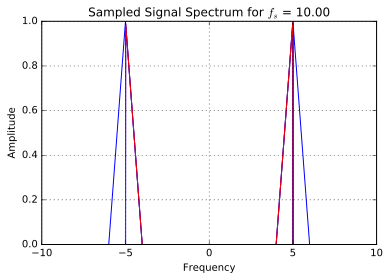

In [5]:
f = arange(-10,10,.01)
BP_spec(f,10.0,8,(4,5))

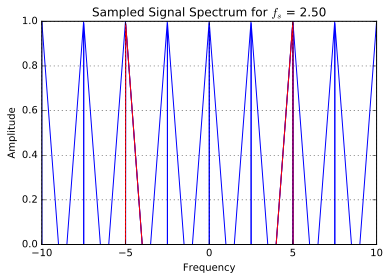

In [32]:
f = arange(-10,10,.01)
BP_spec(f,2.5,8,(4,5))

# Pulse Code Modulation

In [8]:
import digitalcom as dc
#import scipy.special as special

In [9]:
def PCM_encode(x,N_bits):
    """
    x_bits = PCM_encode(x,N_bits)
    /////////////////////////////////////////////////////////////
         x = signal samples to be PCM encoded
    N_bits = bit precision of PCM samples
    x_bits = encoded serial bit stream of 0/1 values. MSB first.
    /////////////////////////////////////////////////////////////
    Mark Wickert, Mark 2015
    """
    xq = np.int16(np.rint(x*2**(N_bits-1)))
    x_bits = np.zeros((N_bits,len(xq)))
    for k, xk in enumerate(xq):
        x_bits[:,k] = tobin(xk,N_bits)
    # Reshape into a serial bit stream
    x_bits = np.reshape(x_bits,(1,len(x)*N_bits),'F')
    return int16(x_bits.flatten())

# A helper function for PCM_encode
def tobin(data, width):
    data_str = bin(data & (2**width-1))[2:].zfill(width)
    return map( int, tuple( data_str ) )

def PCM_decode(x_bits,N_bits):
    """
    xhat = PCM_decode(x_bits,N_bits)
    /////////////////////////////////////////////////////////////
    x_bits = serial bit stream of 0/1 values. The length of 
             x_bits must be a multiple of N_bits
    N_bits = bit precision of PCM samples
      xhat = decoded PCM signal samples
    /////////////////////////////////////////////////////////////
    Mark Wickert, March 2015
    """
    N_samples = len(x_bits)//N_bits
    # Convert serial bit stream into parallel words with each 
    # column holdingthe N_bits binary sample value
    xrs_bits = x_bits.copy()
    xrs_bits = np.reshape(xrs_bits,(N_bits,N_samples),'F')
    # Convert N_bits binary words into signed integer values
    xq = np.zeros(N_samples)
    w = 2**np.arange(N_bits-1,-1,-1) # binary weights for bin 
                                     # to dec conversion
    for k in range(N_samples):
       xq[k] = np.dot(xrs_bits[:,k],w) - xrs_bits[0,k]*2**N_bits
    return xq/2**(N_bits-1)

def AWGN_chan(x_bits,EBN0_dB):
    """
    ////////////////////////////////////////////////////////////////////////
     x_bits = serial bit stream of 0/1 values.
    EBNO_dB = energy per bit to noise power density ratio in dB of the
              serial bit stream sent through the AWGN channel. Frequently
              we equate EBN0 to SNR in link budget calculations
     y_bits = received serial bit stream following hard decisions. This bit
              will have bit errors. To check the estimated bit error
              probability use digitalcom.BPSK_bep() or simply
              >> Pe_est = sum(xor(x_bits,y_bits))/length(x_bits);  
    ////////////////////////////////////////////////////////////////////////
    
    Mark Wickert, March 2015
    """
    x_bits = 2*x_bits - 1 # convert from 0/1 to -1/1 signal values
    var_noise = 10**(-EBN0_dB/10)/2;
    y_bits = x_bits + np.sqrt(var_noise)*np.random.randn(size(x_bits))

    # Make hard decisions
    y_bits = np.sign(y_bits) # -1/+1 signal values
    y_bits = (y_bits+1)/2 # convert back to 0/1 binary values
    return y_bits

## Test With a Sinusoid

(-1, 1)

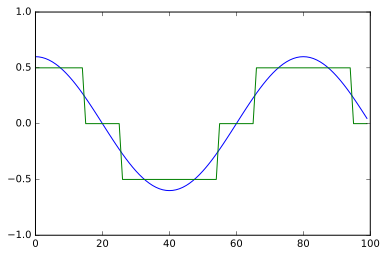

In [80]:
N_bits = 2
EbN0_dB = 50
n = arange(0,100)
x = 0.6*cos(2*pi*n*100/8000)
xe = PCM_encode(x,N_bits) # 8 bits per sample
xer = AWGN_chan(xe,EbN0_dB)
x_hat = PCM_decode(xer,N_bits)
plot(n,x)
plot(n,x_hat)
ylim([-1,1])

## Test with a Speech File
In the past Project 2 has involved PCM encoding and decoding speech with channel impairment.


In [33]:
N = 120000; # number of speech samples to process
fs,m1 = ssd.from_wav('OSR_uk_000_0050_8k.wav')
m1 = m1[20000:N]

In [52]:
EbN0_dB = 20
xe = PCM_encode(m1,7) # 8 bits per sample
xer = AWGN_chan(xe,EbN0_dB)
m1_hat = PCM_decode(xer,8)

In [44]:
total = len(xe)
errors = sum(abs(int16(xer[:100]-xe[:100])))
Pe = errors/total
print('Total Bits = %d' % total)
print('Bit Rrrors = %d' % errors)
print('Bit Error Probability (est) = %1.2e' % (errors/total,))

Total Bits = 400000
Bit Rrrors = 0
Bit Error Probability (est) = 0.00e+00


In [47]:
y_demod = m1_hat
ssd.to_wav('yp2.wav',8000,y_demod)
Audio('yp2.wav')

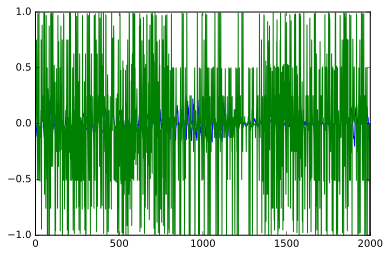

In [53]:
plot(m1[2000:4000])
plot(m1_hat[2000:4000])